In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # basic visualizations 
import seaborn as sns # advanced visualizations

import random
random.seed(42) #We are setting the seed to assure you get the same answers

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving ab_test.csv to ab_test.csv


In [3]:
#read the data and display the top 5 rows
df = pd.read_csv("ab_test.csv")
df.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [4]:
# change column names 
df.columns = ["user_id", "timestamp", "group", "landing_page", "converted"]
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [5]:
#numer of rows and unique users
print(f'Number of rows: {df.shape[0]}')
print(f'Number of unique users: {df.user_id.nunique()}')

Number of rows: 294478
Number of unique users: 290584


In [6]:
#general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [7]:
#missing values
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [8]:
#Does the number of new_page and treatment match?
n_treat = df[df["group"] == "treatment"].shape[0]
n_new_page = df[df["landing_page"] == "new_page"].shape[0]
difference = n_treat - n_new_page

pd.DataFrame({
    'N treatment': [n_treat],
    'N new_page': [n_new_page],
    'Difference': [difference]
})

,N treatment,N new_page,Difference
0,147276,147239,37


In [9]:
# lets see those rows 
df[(df["group"] == "treatment") & (df["landing_page"] == "old_page")]

,user_id,timestamp,group,landing_page,converted
308,857184,34:59.8,treatment,old_page,0
327,686623,26:40.7,treatment,old_page,0
357,856078,29:30.4,treatment,old_page,0
685,666385,11:54.8,treatment,old_page,0
713,748761,47:44.4,treatment,old_page,0
...,...,...,...,...,...
293773,688144,34:50.5,treatment,old_page,1
293817,876037,15:09.0,treatment,old_page,1
293917,738357,37:55.7,treatment,old_page,0
294014,813406,25:33.2,treatment,old_page,0


In [10]:
df_mismatch = df[(df["group"] == "treatment") & (df["landing_page"] == "old_page")
               |(df["group"] == "control") & (df["landing_page"] == "new_page")]

n_mismatch = df_mismatch.shape[0]

percent_mismatch = round(n_mismatch / len(df) * 100, 2)
print(f'Number of mismatched rows: {n_mismatch} rows')
print(f'Percent of mismatched rows: {percent_mismatch} percent')

Number of mismatched rows: 3893 rows
Percent of mismatched rows: 1.32 percent


In [11]:
df2 = df[(df["group"] == "treatment") & (df["landing_page"] == "new_page")
        |(df["group"] == "control") & (df["landing_page"] == "old_page")]

len(df2)

290585

In [12]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [14]:
# Another way to double Check all of the correct rows were removed 
df_mismatch = df2[(df2["group"] == "treatment") & (df2["landing_page"] == "old_page")
               |(df2["group"] == "control") & (df2["landing_page"] == "new_page")]

n_mismatch = df_mismatch.shape[0]

percent_mismatch = round(n_mismatch / len(df2) * 100, 2)
print(f'Number of mismatched rows: {n_mismatch} rows')
print(f'Percent of mismatched rows: {percent_mismatch} percent')

Number of mismatched rows: 0 rows
Percent of mismatched rows: 0.0 percent


In [15]:
# unique user id in df2 
df2.user_id.nunique()

290584

In [16]:
# number of repeated ids in df2
len(df2) - df2.user_id.nunique()

1

In [17]:
# Display the duplicated row 
df2[df2.duplicated("user_id") == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,55:59.6,treatment,new_page,0


In [18]:
#drop the duplicated row
df2 = df2.drop_duplicates("user_id") 

In [19]:
# Douple Check that it is actually dropped
len(df2) - df2.user_id.nunique()

0

In [20]:
#Probablity
# Percent of convergance
# The probability of an individual converting regardless of the page they receive
df2.converted.mean() * 100

11.959708724499627

In [21]:
#Given that an individual was in the control group, what is the probability they converted?
#Given that an individual was in the treatment group, what is the probability they converted?
df2.user_id = df2.user_id.astype(str)
df2.groupby("group").mean() * 100

,converted
group,
control,12.038630
treatment,11.880807


In [22]:
#What is the probability that an individual received the new page?
pd.DataFrame(df2.landing_page.value_counts(normalize = True) * 100)

,landing_page
new_page,50.006194
old_page,49.993806


In [ ]:
# Creating the sampling distribution of difference in means 
means_diff = []
size = df.shape[0]
for _ in range(10000):
    sample = df2.sample(size, replace = True)
    control_mean = sample[sample["group"] == "control"]["converted"].mean()
    treat_mean = sample[sample["group"] == "treatment"]["converted"].mean()
    means_diff.append(treat_mean - control_mean)

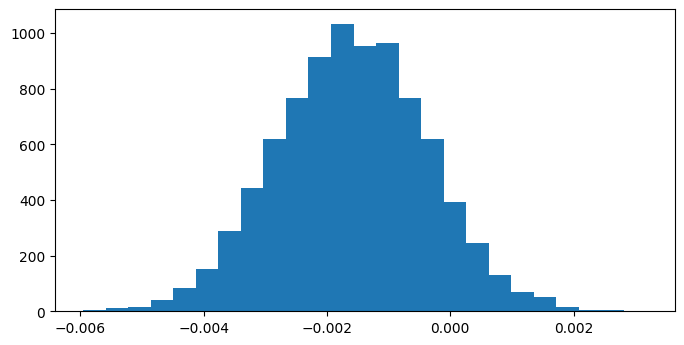

In [24]:
# Plotting the sampling distribution 
plt.figure(figsize = (8,4), dpi = 100)
plt.hist(means_diff, bins = 25)
plt.show()

In [26]:
# Simulate distribution under the null hypothesis
means_diff = np.array(means_diff)
null_vals = np.random.normal(0, means_diff.std(), means_diff.size)

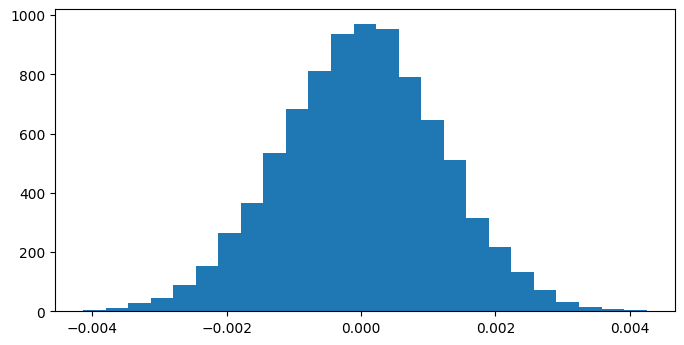

In [27]:
# Plot the null distribution
plt.figure(figsize = (8,4), dpi = 100)
plt.hist(null_vals, bins = 25)
plt.show()

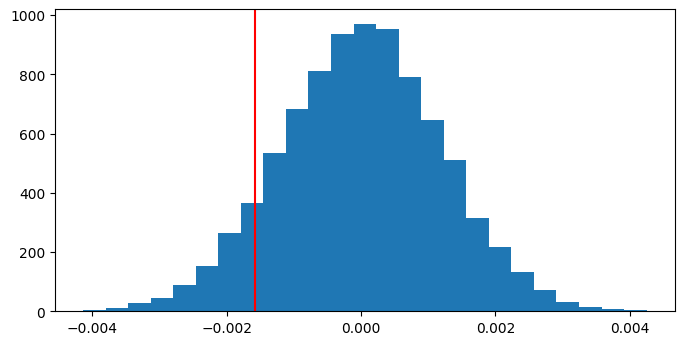

In [28]:
# Plot observed statistic with the null distibution
control_mean = df2[df2["group"] == "control"]["converted"].mean()
treat_mean = df2[df2["group"] == "treatment"]["converted"].mean()
obs_diff = treat_mean - control_mean

plt.figure(figsize = (8,4), dpi = 100)
plt.hist(null_vals, bins = 25)
plt.axvline(obs_diff, c='red')
plt.show()

In [29]:
# calculating the p value 
(null_vals > obs_diff).mean()

0.905515475913428

In [30]:
import statsmodels.api as sm

convert_old = df2[(df2["converted"] == 1) & (df2["landing_page"] == "old_page")]['user_id'].nunique()
convert_new = df2[(df2["converted"] == 1) & (df2["landing_page"] == "new_page")]['user_id'].nunique()
n_old = df2[df["landing_page"] == "old_page"]['user_id'].nunique()
n_new = df2[df["landing_page"] == "new_page"]['user_id'].nunique()

In [31]:
#Compute test statistic and p-value
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')

In [32]:
# Print Z Score and P_Value
z_score, p_value 

(-1.3109241984234394, 0.9050583127590245)

In [33]:
# Creat the intercept 
df2["intercept"] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept
0,851104,11:48.6,control,old_page,0,1
1,804228,01:45.2,control,old_page,0,1
2,661590,55:06.2,treatment,new_page,0,1
3,853541,28:03.1,treatment,new_page,0,1
4,864975,52:26.2,control,old_page,1,1


In [34]:
# Create ab_page column, which is 1 when an individual receives the treatment and 0 if control.
df2["ab_page"] = df2.group.apply(lambda x: 1 if (x == "treatment") else 0)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,11:48.6,control,old_page,0,1,0
1,804228,01:45.2,control,old_page,0,1,0
2,661590,55:06.2,treatment,new_page,0,1,1
3,853541,28:03.1,treatment,new_page,0,1,1
4,864975,52:26.2,control,old_page,1,1,0


In [35]:
# Instantiate and fit the regression model
model = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
result = model.fit()
result.summary()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jul 2021   Pseudo R-squ.:               8.077e-06
Time:                        15:14:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [36]:
from google.colab import files
uploaded = files.upload()

Saving countries_ab.csv to countries_ab.csv


In [37]:
# Read the country data
countries = pd.read_csv("countries_ab.csv")
countries.head()

,id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [38]:
# Merge the countries dataframe with df2 
countries.columns = ["user_id", "country"]
countries["user_id"] = countries["user_id"].astype(str)
df3 = df2.merge(countries, on = "user_id", how = "left")
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,11:48.6,control,old_page,0,1,0,US
1,804228,01:45.2,control,old_page,0,1,0,US
2,661590,55:06.2,treatment,new_page,0,1,1,US
3,853541,28:03.1,treatment,new_page,0,1,1,US
4,864975,52:26.2,control,old_page,1,1,0,US


In [39]:
# creating dummies for country and landing_page columns 
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3[['new_page','old_page']] = pd.get_dummies(df3['landing_page'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,new_page,old_page
0,851104,11:48.6,control,old_page,0,1,0,US,0,0,1,0,1
1,804228,01:45.2,control,old_page,0,1,0,US,0,0,1,0,1
2,661590,55:06.2,treatment,new_page,0,1,1,US,0,0,1,1,0
3,853541,28:03.1,treatment,new_page,0,1,1,US,0,0,1,1,0
4,864975,52:26.2,control,old_page,1,1,0,US,0,0,1,0,1


In [40]:
# lest see if there is a relation between country and conversion
pd.pivot_table(data = df3, index = "country", values = "converted").sort_values(by = "converted", ascending = False) * 100

,converted
country,
UK,12.059449
US,11.954680
CA,11.531830


In [41]:
# Instantiate and fit the regression model with country as an additional variable: 'CA' is a baseline
model = sm.Logit(df3['converted'], df3[['intercept','ab_page', 'UK','US']])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 08 Jul 2021   Pseudo R-squ.:               2.323e-05
Time:                        15:17:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [42]:
# exponentiate the parameters to inteprete the result
np.exp(result.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64